In [98]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy.random import randn
np.random.seed(0)
import pickle
import gzip
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle
from tqdm import tqdm

import time
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
from sympy.utilities.codegen import codegen
init_printing(use_latex=True)

In [2]:
# data loading

data_ver = '3'

# NOISE
with gzip.open(f'../data/segment_with_noise_v{data_ver}/ll_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    ll_seg_noise = pickle.load(f)
with gzip.open(f'../data/segment_with_noise_v{data_ver}/rl_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    rl_seg_noise = pickle.load(f)

# GROUND TRUTH
with gzip.open(f'../data/segment_groud_truth_v2/rl_seg_gt_500_v2.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open(f'../data/segment_groud_truth_v2/ll_seg_gt_500_v2.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_noise))
print(ll_seg_noise[0].shape[0])
ll_seg_noise[0].head()

500
153


,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,omega_Zv,alpha_Xv,alpha_Yv,lane,y_noise,x_noise
68268,274.111469,109.920335,0.00,5.87,152.640,0.634,1.101,0.47,0.36,0.60,0.237,-0.150,1,274.552482,109.713725
68293,272.808525,110.598795,-0.01,5.88,152.633,0.648,1.087,-0.81,1.00,-0.26,0.212,-0.143,1,272.908564,110.574182
68318,271.504469,111.278905,0.00,5.90,152.626,0.677,1.130,-0.01,-0.45,-0.20,0.320,-0.018,1,271.749154,111.113036
68343,270.195971,111.961492,-0.01,5.91,152.607,0.720,1.148,-1.15,-0.40,0.47,0.242,-0.473,1,270.756194,112.243151
68368,268.884140,112.646555,-0.01,5.93,152.600,0.716,1.147,0.52,-0.02,-0.34,0.054,-0.277,1,269.351030,112.376572


In [3]:
# sample_freq = 50 # 5hz
sample_freq = 25 # 10hz
dt = 0.01 * sample_freq
dt

In [62]:
sample_traj = ll_seg_noise[201]
sample_traj.head()

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,omega_Zv,alpha_Xv,alpha_Yv,lane,y_noise,x_noise
22302,717.822536,1209.676767,-0.02,5.24,357.536,0.891,2.125,-1.02,-0.29,0.06,0.124,-0.397,1,717.876258,1209.933827
22327,719.128814,1209.618994,-0.01,5.23,357.499,0.923,2.112,-0.42,-0.06,0.06,0.076,-0.426,1,719.091238,1209.485545
22352,720.433981,1209.558746,-0.01,5.22,357.482,0.980,2.045,-0.38,0.43,-0.08,0.135,-0.345,1,720.023939,1209.522587
22377,721.736926,1209.498497,-0.02,5.22,357.453,1.023,1.993,-0.27,0.64,-0.11,0.243,-0.361,1,721.614922,1209.252199
22402,723.040982,1209.438248,-0.01,5.22,357.416,0.997,1.927,-0.27,0.27,-0.29,0.146,-0.349,1,723.069575,1209.427037


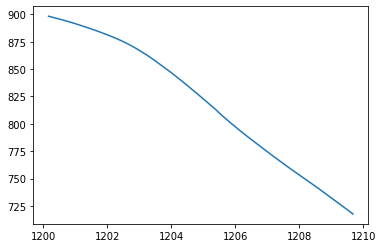

In [63]:
plt.plot(sample_traj['x'], sample_traj['y'])

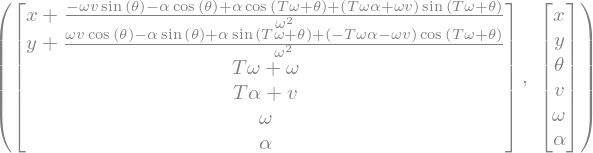

In [7]:
v, theta, omega, dts, x, y, lat, lon, alpha = symbols('v theta \omega T x y lat lon alpha')

# transition matrix
gs = Matrix([[x + (1 / omega**2) * ((v*omega + alpha * omega * dts) * sin(theta + omega * dts) + alpha * cos(theta + omega * dts) - v * omega * sin(theta) - alpha * cos(theta))],    
             [y + (1 / omega**2) * ((-v*omega - alpha * omega * dts) * cos(theta + omega * dts) + alpha * sin(theta + omega * dts) + v * omega * cos(theta) - alpha * sin(theta))],
             [omega + omega*dts],
             [alpha*dts + v],
             [omega],
             [alpha]])

# state vector             
state = Matrix([x, y, theta, v, omega, alpha])
gs, state

In [8]:
state

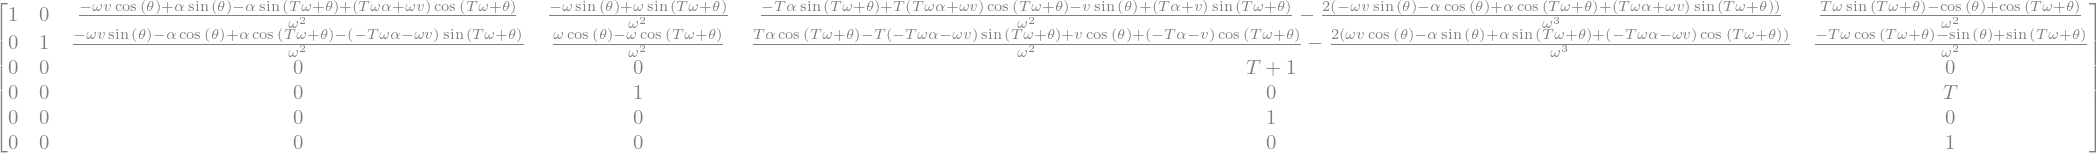

In [9]:
gs.jacobian(state)

In [78]:
# P0 matrix
P = 5 * np.eye(len(state))
print(P, P.shape)
print()

max_Vx = 6.5 # m/s
max_alpha_Vx = 2.193 # m/s2
max_omega_Zv = 1.56 # deg/s
max_omega_Zv_accel = 1 # deg/s2

s_gps = 0.5 * max_alpha_Vx * dt ** 2
s_yaw = max_omega_Zv * dt
s_vel = max_Vx * dt
s_omega = 1.0 * dt
s_accel = max_alpha_Vx * 0.5

sig_gps = 2
sig_theta = 0*dt
sig_vel = 3*dt
sig_omega = 0*dt
sig_accel = 1
sig_yaw_rate = 0.1

# Process noise covariance Q matrix
# assume the processes are indepedent of each other
Q = np.diag([
    s_gps**2, s_gps**2, s_yaw**2, s_vel**2, s_omega**2, s_accel**2
])

print(Q, Q.shape)
print()

# Measurement covariance R matrix

R = np.diag(
    [sig_gps**2, sig_gps**2, sig_vel**2, sig_yaw_rate**2, sig_accel**2]
)
print(R, R.shape)

I = np.eye(len(state))

# measurement function, H

H = np.array([
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
])

[[5. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0.]
 [0. 0. 0. 5. 0. 0.]
 [0. 0. 0. 0. 5. 0.]
 [0. 0. 0. 0. 0. 5.]] (6, 6)

[[0.00469653 0.         0.         0.         0.         0.        ]
 [0.         0.00469653 0.         0.         0.         0.        ]
 [0.         0.         0.1521     0.         0.         0.        ]
 [0.         0.         0.         2.640625   0.         0.        ]
 [0.         0.         0.         0.         0.0625     0.        ]
 [0.         0.         0.         0.         0.         1.20231225]] (6, 6)

[[4.     0.     0.     0.     0.    ]
 [0.     4.     0.     0.     0.    ]
 [0.     0.     0.5625 0.     0.    ]
 [0.     0.     0.     0.01   0.    ]
 [0.     0.     0.     0.     1.    ]] (5, 5)


In [23]:
def ekf_6_stats(segment_df):

    x_noise = segment_df['x_noise'].values
    y_noise = segment_df['y_noise'].values
    Vx = segment_df['Vx'].values
    alpha_Xv = segment_df['alpha_Xv'].values
    theta = segment_df['theta'].values/180.0*np.pi             # rad
    omega_Zv = segment_df['omega_Zv'].values/180.0*np.pi       # rad/s

    x = np.matrix([
        x_noise[0], y_noise[0], theta[0], Vx[0], omega_Zv[0], alpha_Xv[0]
    ]).T

    observations = np.vstack((
        x_noise, y_noise, Vx, omega_Zv, alpha_Xv
    ))

    P = 5 * np.eye(len(state))
    
    Q = np.diag([
        s_gps**2, s_gps**2, s_yaw**2, s_vel**2, s_omega**2, s_accel**2
    ])

    # Measurement covariance R matrix
    R = np.diag(
        [sig_gps**2, sig_gps**2, sig_vel**2, sig_yaw_rate**2, sig_accel**2]
    )

    I = np.eye(len(state))

    # measurement function, H
    H = np.array([
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    ])

    m = observations.shape[1]
    nx = Q.shape[0]
    ny = R.shape[0]

    x_est = np.zeros((m, nx))      # prediction of state vector                                                       

    for filterstep in range(m):
        
        x[0] = x[0] + (1 / x[4]**2) * ((x[3]*x[4] + x[5] * x[4] * dt) * \
            np.sin(x[2] + x[4]* dt) + x[5] * np.cos(x[2] + x[4] * dt) - x[3] *  \
            x[4] * np.sin(x[2]) - x[5] * np.cos(x[2]))
        x[1] = x[1] + (1 / x[4]**2) * ((-x[3]*x[4] - x[5] * x[4] * dt) * \
            np.cos(x[2] + x[4]* dt) + x[5] * np.sin(x[2] + x[4] * dt) + x[3] * \
            x[4] * np.cos(x[2]) - x[5] * np.sin(x[2]))
        x[2] = (x[2] + x[4] * dt)#  + np.pi) % (2.0 * np.pi) - np.pi
        x[3] = x[3] + x[5] * dt 
        x[4] = x[4]
        x[5] = x[5]
        
        
        # Calculate the Jacobian of the Dynamic Matrix A
        # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
        a13 = ((-x[4]*x[3]*np.cos(x[2]) + x[5]*np.sin(x[2]) - x[5]*np.sin(dt*x[4] + x[2]) + \
            (dt*x[4]*x[5] + x[4]*x[3])*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)

        a14 = ((-x[4]*np.sin(x[2]) + x[4]*np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)

        a15 = ((-dt*x[5]*np.sin(dt*x[4] + x[2]) + dt*(dt*x[4]*x[5] + x[4]*x[3])* \
            np.cos(dt*x[4] + x[2]) - x[3]*np.sin(x[2]) + (dt*x[5] + x[3])* \
            np.sin(dt*x[4] + x[2]))/x[4]**2 - 2*(-x[4]*x[3]*np.sin(x[2]) - x[5]* \
            np.cos(x[2]) + x[5]*np.cos(dt*x[4] + x[2]) + (dt*x[4]*x[5] + x[4]*x[3])* \
            np.sin(dt*x[4] + x[2]))/x[4]**3).item(0)

        a16 = ((dt*x[4]*np.sin(dt*x[4] + x[2]) - np.cos(x[2]) + np.cos(dt * x[4] + x[2]))/x[4]**2).item(0)

        a23 = ((-x[4] * x[3] * np.sin(x[2]) - x[5] * np.cos(x[2]) + x[5] * np.cos(dt * x[4] + x[2]) - \
            (-dt * x[4]*x[5] - x[4] * x[3]) * np.sin(dt * x[4] + x[2])) / x[4]**2).item(0)
        a24 = ((x[4] * np.cos(x[2]) - x[4]*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)
        a25 = ((dt * x[5]*np.cos(dt*x[4] + x[2]) - dt * (-dt*x[4]*x[5] - x[4] * x[3]) * \
            np.sin(dt * x[4] + x[2]) + x[3]*np.cos(x[2]) + (-dt*x[5] - x[3])*np.cos(dt*x[4] + x[2]))/ \
            x[4]**2 - 2*(x[4]*x[3]*np.cos(x[2]) - x[5] * np.sin(x[2]) + x[5] * np.sin(dt*x[4] + x[2]) + \
            (-dt * x[4] * x[5] - x[4] * x[3])*np.cos(dt*x[4] + x[2]))/x[4]**3).item(0)
        a26 =  ((-dt*x[4]*np.cos(dt*x[4] + x[2]) - np.sin(x[2]) + np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)
            
        JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                        [0.0, 1.0, a23, a24, a25, a26],
                        [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
        
        
        # Project the error covariance ahead
        P = JA * P * JA.T + Q
        
        # Measurement Update (Correction)
        # ===============================
        # Measurement Function
        hx = np.matrix([[float(x[0])],
                        [float(x[1])],
                        [float(x[3])],
                        [float(x[4])],
                        [float(x[5])]])        
        
        S = H * P * H.T + R
        K = (P * H.T) * np.linalg.inv(S)

        # Update the estimate via
        Z = observations[:,filterstep].reshape(H.shape[0],1)
        y = Z - (hx)                         # Innovation or Residual
        x = x + (K * y)

        # Update the error covariance
        P = (I - (K * H)) * P

        x_est[filterstep] = x.T

    return x_est, x_noise, y_noise, segment_df['x'].values, segment_df['y'].values

In [52]:
x_est_sample, x_noise, y_noise, x, y = ekf_6_stats(sample_traj)

In [79]:
# measurements

x_noise = sample_traj['x_noise'].values
y_noise = sample_traj['y_noise'].values
Vx = sample_traj['Vx'].values
alpha_Xv = sample_traj['alpha_Xv'].values
theta = sample_traj['theta'].values/180.0*np.pi             # rad
omega_Zv = sample_traj['omega_Zv'].values/180.0*np.pi       # rad/s

x = np.matrix([
    x_noise[0], y_noise[0], theta[0], Vx[0], np.average(omega_Zv), np.average(alpha_Xv)
]).T

observations = np.vstack((
    x_noise, y_noise, Vx, omega_Zv, alpha_Xv
))

m = observations.shape[1]
print(observations.shape[1])

# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
dstate=[]

153


In [81]:
for filterstep in range(m):

    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    
    # if np.abs(observations[2][filterstep]) < 0.0001: # Driving straight
    #     x[4] = 0.0001
    
    x[0] = x[0] + (1 / x[4]**2) * ((x[3]*x[4] + x[5] * x[4] * dt) * \
        np.sin(x[2] + x[4]* dt) + x[5] * np.cos(x[2] + x[4] * dt) - x[3] *  \
        x[4] * np.sin(x[2]) - x[5] * np.cos(x[2]))
    x[1] = x[1] + (1 / x[4]**2) * ((-x[3]*x[4] - x[5] * x[4] * dt) * \
        np.cos(x[2] + x[4]* dt) + x[5] * np.sin(x[2] + x[4] * dt) + x[3] * \
        x[4] * np.cos(x[2]) - x[5] * np.sin(x[2]))
    x[2] = (x[2] + x[4] * dt)#  + np.pi) % (2.0 * np.pi) - np.pi
    x[3] = x[3] + x[5] * dt 
    x[4] = x[4]
    x[5] = x[5]
    
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = ((-x[4]*x[3]*np.cos(x[2]) + x[5]*np.sin(x[2]) - x[5]*np.sin(dt*x[4] + x[2]) + \
        (dt*x[4]*x[5] + x[4]*x[3])*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)

    a14 = ((-x[4]*np.sin(x[2]) + x[4]*np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)

    a15 = ((-dt*x[5]*np.sin(dt*x[4] + x[2]) + dt*(dt*x[4]*x[5] + x[4]*x[3])* \
        np.cos(dt*x[4] + x[2]) - x[3]*np.sin(x[2]) + (dt*x[5] + x[3])* \
        np.sin(dt*x[4] + x[2]))/x[4]**2 - 2*(-x[4]*x[3]*np.sin(x[2]) - x[5]* \
        np.cos(x[2]) + x[5]*np.cos(dt*x[4] + x[2]) + (dt*x[4]*x[5] + x[4]*x[3])* \
        np.sin(dt*x[4] + x[2]))/x[4]**3).item(0)

    a16 = ((dt*x[4]*np.sin(dt*x[4] + x[2]) - np.cos(x[2]) + np.cos(dt * x[4] + x[2]))/x[4]**2).item(0)

    a23 = ((-x[4] * x[3] * np.sin(x[2]) - x[5] * np.cos(x[2]) + x[5] * np.cos(dt * x[4] + x[2]) - \
        (-dt * x[4]*x[5] - x[4] * x[3]) * np.sin(dt * x[4] + x[2])) / x[4]**2).item(0)
    a24 = ((x[4] * np.cos(x[2]) - x[4]*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)
    a25 = ((dt * x[5]*np.cos(dt*x[4] + x[2]) - dt * (-dt*x[4]*x[5] - x[4] * x[3]) * \
        np.sin(dt * x[4] + x[2]) + x[3]*np.cos(x[2]) + (-dt*x[5] - x[3])*np.cos(dt*x[4] + x[2]))/ \
        x[4]**2 - 2*(x[4]*x[3]*np.cos(x[2]) - x[5] * np.sin(x[2]) + x[5] * np.sin(dt*x[4] + x[2]) + \
        (-dt * x[4] * x[5] - x[4] * x[3])*np.cos(dt*x[4] + x[2]))/x[4]**3).item(0)
    a26 =  ((-dt*x[4]*np.cos(dt*x[4] + x[2]) - np.sin(x[2]) + np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)
        
    JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                    [0.0, 1.0, a23, a24, a25, a26],
                    [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    
    # Project the error covariance ahead
    P = JA * P * JA.T + Q
    
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])]])        
    
    S = H * P * H.T + R
    K = (P * H.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = observations[:,filterstep].reshape(H.shape[0],1)
    y = Z - (hx)                         # Innovation or Residual
    x = x + (K * y)

    # Update the error covariance
    P = (I - (K * H)) * P


    # Save states for Plotting
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))

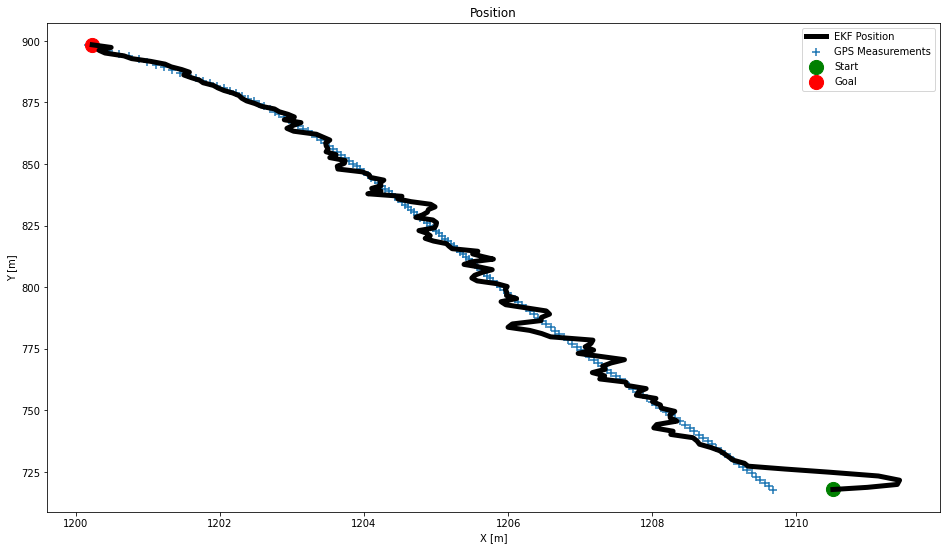

In [82]:
fig = plt.figure(figsize=(16,9))

# EKF State
plt.plot(x0, x1, label='EKF Position', c='k', lw=5)

# Measurements
plt.scatter(sample_traj['x'], sample_traj['y'], s=50, label='GPS Measurements', marker='+')
#cbar=plt.colorbar(ticks=np.arange(20))
#cbar.ax.set_ylabel(u'EPE', rotation=270)
#cbar.ax.set_xlabel(u'm')

# Start/Goal
plt.scatter(x0[0], x1[0], s=200, label='Start', c='g')
plt.scatter(x0[-1], x1[-1], s=200, label='Goal', c='r')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Position')
plt.legend(loc='best')
# plt.axis('equal')

Text(0.5, 0, 'Filter Step')

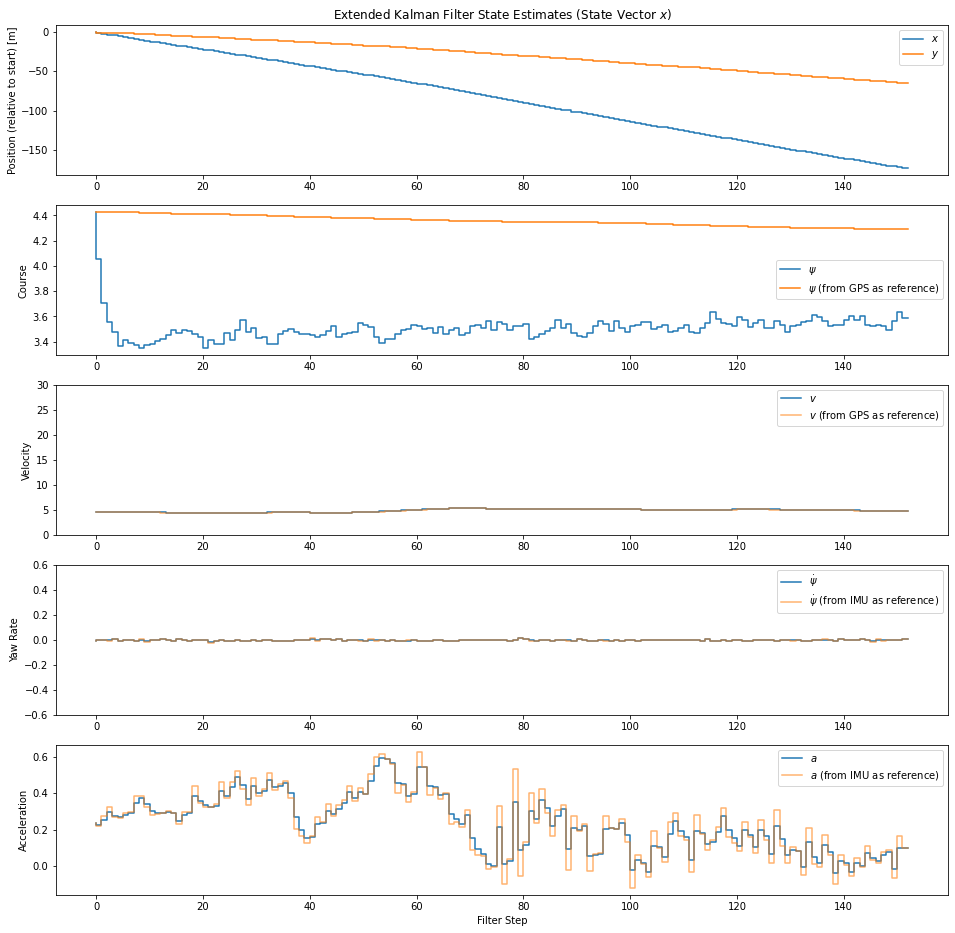

In [245]:
fig = plt.figure(figsize=(16,16))

plt.subplot(511)
plt.step(range(len(observations[0])),x0-x_noise[0], label='$x$')
plt.step(range(len(observations[0])),x1-y_noise[0], label='$y$')

plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
plt.legend(loc='best')
plt.ylabel('Position (relative to start) [m]')

plt.subplot(512)
plt.step(range(len(observations[0])), x2, label='$\psi$')
plt.step(range(len(observations[0])), theta, label='$\psi$ (from GPS as reference)')
plt.ylabel('Course')
plt.legend(loc='best')
           
plt.subplot(513)
plt.step(range(len(observations[0])),x3, label='$v$')
plt.step(range(len(observations[0])),Vx, label='$v$ (from GPS as reference)', alpha=0.6)
plt.ylabel('Velocity')
plt.ylim([0, 30])
plt.legend(loc='best')

plt.subplot(514)
plt.step(range(len(observations[0])),x4, label='$\dot \psi$')
plt.step(range(len(observations[0])),omega_Zv, label='$\dot \psi$ (from IMU as reference)', alpha=0.6)
plt.ylabel('Yaw Rate')
plt.ylim([-0.6, 0.6])
plt.legend(loc='best')

plt.subplot(515)
plt.step(range(len(observations[0])),x5, label='$a$')
plt.step(range(len(observations[0])),alpha_Xv, label='$a$ (from IMU as reference)', alpha=0.6)
plt.ylabel('Acceleration')
#plt.ylim([-0.6, 0.6])
plt.legend(loc='best')
plt.xlabel('Filter Step')

# plt.savefig('Extended-Kalman-Filter-CTRA-State-Estimates.png', dpi=72, transparent=True, bbox_inches='tight')

In [83]:
pred_err = []
noise_err = []

x_gt = sample_traj['x'].values
y_gt = sample_traj['y'].values


for i in np.arange(m):
    pred_coord = (x0[i], x1[i])
    gt_coord = (x_gt[i], y_gt[i])
    noise_coord = (x_noise[i], y_noise[i])
    
    pred_err.append(math.dist(pred_coord, gt_coord)) # meter
    noise_err.append(math.dist(noise_coord, gt_coord)) # meter

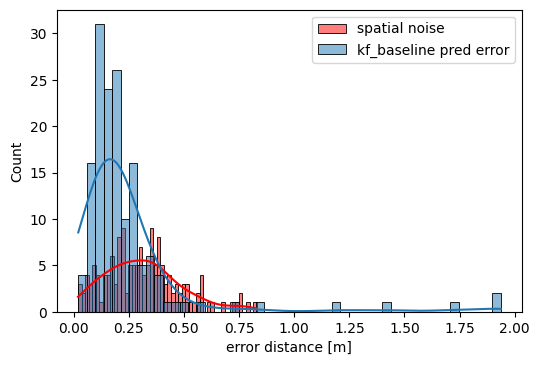

In [84]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    bins=50, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    bins=50, label='kf_baseline pred error', kde=True)

plt.xlabel('error distance [m]')
plt.legend()
plt.show()

In [26]:
# runtime ~= 5s
# list of dataframe
rl_seg_pred = []

for df in rl_seg_noise:
    x_est_sample, x_noise, y_noise, x, y = ekf_6_stats(df)
    x_est_df = pd.DataFrame({
        'x_est': x_est_sample[:, 0],
        'y_est': x_est_sample[:, 1],
        'theta': x_est_sample[:, 2],
        'Vx_est': x_est_sample[:, 3],
        'x_noise': x_noise,
        'y_noise': y_noise,
        'x': x,
        'y': y
        }
    )
    rl_seg_pred.append(x_est_df)  

In [31]:
rl_seg_pred[0]

,x_est,y_est,theta,Vx_est,x_noise,y_noise,x,y
0,109.142331,274.846182,2.668120,5.860278,109.713725,274.552482,109.920335,274.111469
1,108.637178,274.180970,2.992209,5.870691,110.574182,272.908564,110.598795,272.808525
2,108.086834,273.127431,3.301520,5.887511,111.113036,271.749154,111.278905,271.504469
3,107.839627,271.750029,3.632855,5.894277,112.243151,270.756194,111.961492,270.195971
4,107.903078,269.722406,4.118119,5.911519,112.376572,269.351030,112.646555,268.884140
...,...,...,...,...,...,...,...,...
148,213.300393,99.423196,5.403406,4.607805,213.680835,99.139080,213.266303,99.468057
149,214.019266,98.521549,5.393096,4.586772,214.010159,98.504026,214.039700,98.619422
150,214.733749,97.643366,5.390476,4.574390,214.644703,97.761502,214.814748,97.778562
151,215.673060,96.966607,5.472522,4.545780,215.757217,97.373813,215.590621,96.945477


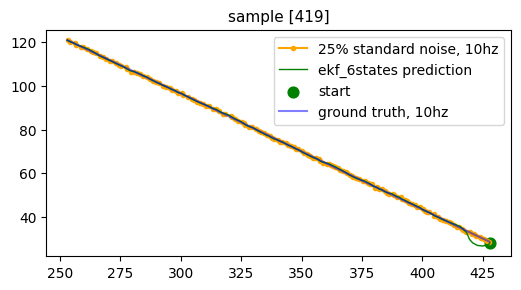

In [140]:
sample = 419
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(rl_seg_pred[sample]['y_noise'], rl_seg_pred[sample]['x_noise'], '-o', label='25% standard noise, 10hz', ms=3, c='orange')
plt.plot(rl_seg_pred[sample]['y_est'], rl_seg_pred[sample]['x_est'], '-', linewidth=1, label='ekf_6states prediction', c='green')
plt.scatter(rl_seg_pred[sample]['y_est'][0], rl_seg_pred[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(rl_seg_pred[sample]['y'], rl_seg_pred[sample]['x'], label='ground truth, 10hz', c='blue', alpha=0.5)
plt.title(f'sample [{sample}]', fontsize=11)
plt.legend()
plt.show()

In [96]:
def traj_distances_proj(df):

    length_m = 0
    length_m_pred = 0
    length_m_noise = 0

    for index, row in df.iterrows():
        try:
            # actual
            start = (row['y'], row['x'])
            end = (df.iloc[index+1]['y'], df.iloc[index+1]['x'])
            length_m += math.dist(start, end)

            # predicted
            start = (row['y_est'], row['x_est'])
            end = (df.iloc[index+1]['y_est'], df.iloc[index+1]['x_est'])
            length_m_pred += math.dist(start, end)

            # noise
            start = (row['y_noise'], row['x_noise'])
            end = (df.iloc[index+1]['y_noise'], df.iloc[index+1]['x_noise'])
            length_m_noise += math.dist(start, end)

        except:
            pass
    
    return length_m, length_m_pred, length_m_noise

In [86]:
pred_err = []
noise_err = []

for j in np.arange(len(rl_seg_pred)):

    x_gt = rl_seg_pred[j]['x'].values
    y_gt = rl_seg_pred[j]['y'].values
    x_est = rl_seg_pred[j]['x_est'].values
    y_est = rl_seg_pred[j]['y_est'].values
    x_noise = rl_seg_pred[j]['x_noise'].values
    y_noise = rl_seg_pred[j]['y_noise'].values

    for i in np.arange(m):
        pred_coord = (x_est[i], y_est[i])
        gt_coord = (x_gt[i], y_gt[i])
        noise_coord = (x_noise[i], y_noise[i])
        
        pred_err.append(math.dist(pred_coord, gt_coord)) # meter
        noise_err.append(math.dist(noise_coord, gt_coord)) # meter

Text(0.5, 0, 'ekf_6states pred error')

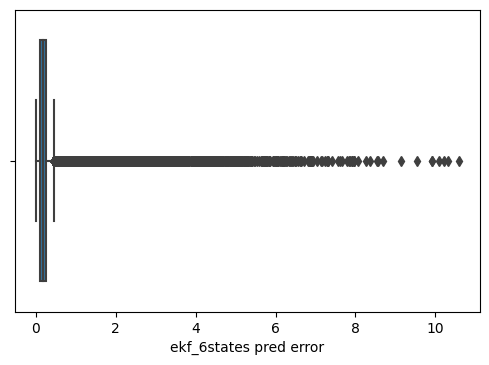

In [99]:
sns.boxplot(pred_err)
plt.xlabel('ekf_6states pred error')


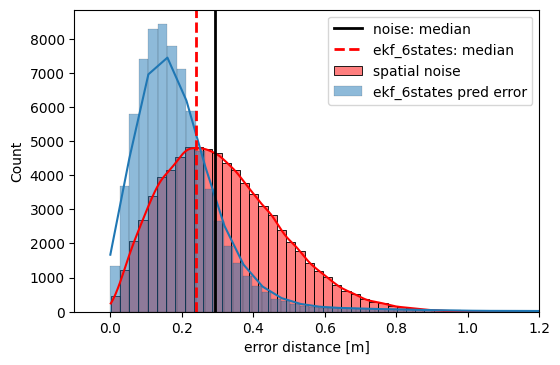

In [125]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    bins=50, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    bins=400, label='ekf_6states pred error', kde=True)

ax.axvline(np.median(noise_err), color='k', lw=2, label='noise: median')
ax.axvline(np.nanmean(np.array(pred_err)), color='red', ls='--', lw=2, label='ekf_6states: median')

plt.xlabel('error distance [m]')
plt.xlim([-0.1, 1.2])
plt.legend()
plt.show()

In [101]:
length_m_lst = []
length_m_pred_lst = []
length_m_noise_lst = []

for df in tqdm(rl_seg_pred):
    length_m, length_m_pred, length_m_noise = traj_distances_proj(df)
    length_m_lst.append(length_m)
    length_m_pred_lst.append(length_m_pred)
    length_m_noise_lst.append(length_m_noise)

100%|██████████| 500/500 [00:33<00:00, 15.15it/s]


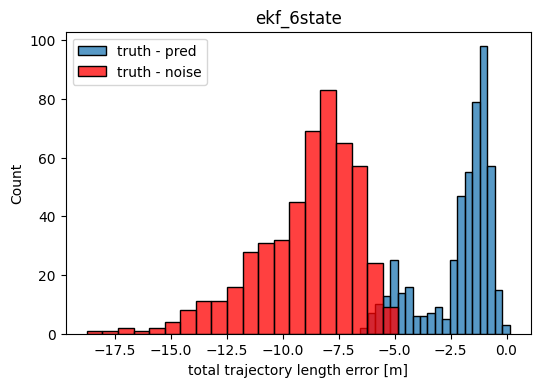

In [126]:
plt.figure(dpi=100)
sns.histplot(np.array(length_m_lst) - np.array(length_m_pred_lst), label='truth - pred')
sns.histplot(np.array(length_m_lst) - np.array(length_m_noise_lst), label='truth - noise', color='red')
plt.title('ekf_6state')
plt.xlabel('total trajectory length error [m]')
plt.legend()